See my notebook [here](https://colab.research.google.com/drive/1MY6pk3vY7rrYal8oS6_s7zTkGN9lkHQr?usp=sharing) demonstrating how to use my code to train a NeRF model on the `tiny_nerf_data.npz` file used by the original NeRF authors in their notebook [here](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb).

In [1]:
!pip install -q matplotlib numpy torch natsort

In [2]:
!pip install -q -U einops datasets tqdm

In [26]:
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import os
from natsort import natsorted

from torch import nn, optim, einsum

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import math
from einops import rearrange

In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [5]:
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [6]:
# ResNet18
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, down_sample=False, groups=1,
                 base_width=64, dilation=1, time_dim=None, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        self.scale_shift_mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_dim, planes * 2))
        )
                
        self.inplanes = inplanes
        self.planes = planes
        self.down_sample = down_sample

        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.conv1x1 = conv1x1(self.inplanes, self.planes, stride)
        

    def forward(self, x, time_emb):

        #scale_shift
        time_emb = self.scale_shift_mlp(time_emb)
        time_emb = rearrange(time_emb, "b c -> b c 1 1")
        scale_shift = time_emb.chunk(2, dim=1)


        identity = x

        out = self.conv1(x)
        out = self.bn1(out)

        scale, shift = scale_shift
        out = out * (scale + 1) + shift

        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.down_sample == True:
          identity = self.conv1x1(identity)
          identity = self.bn1(identity)

        #print(out.shape, identity.shape)
        out += identity #残差結合
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()


        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.norm_layer = norm_layer

        #入力チャンネル
        self.inplanes = 64
        self.dilation = 1
        self.time_dim = self.inplanes * 4

        #if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
        #    replace_stride_with_dilation = [False, False, False]
        #if len(replace_stride_with_dilation) != 3:
        #    raise ValueError("replace_stride_with_dilation should be None "
        #                     "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        #Time_Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(self.inplanes),
            nn.Linear(self.inplanes, self.time_dim),
            nn.GELU(),
            nn.Linear(self.time_dim, self.time_dim),
        )

        #畳み込み1
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        #Attention
        self.attn = LinearAttention(self.inplanes)

        #正則化
        self.bn1 = norm_layer(self.inplanes)

        #活性化
        self.relu = nn.ReLU(inplace=True)

        #プーリング
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #ResNet ブロック
        self.layer1 = block(inplanes = self.inplanes, planes = 64, norm_layer = self.norm_layer, time_dim=self.time_dim)
            
        self.layer2 = block(inplanes = 64, planes = 128, stride=2, down_sample = True, norm_layer = self.norm_layer, time_dim=self.time_dim)

        self.layer3 = block(inplanes = 128, planes = 256, stride=2, down_sample = True, norm_layer = self.norm_layer, time_dim=self.time_dim)

        self.layer4 = block(inplanes = 256, planes = 512, stride=2, down_sample = True, norm_layer = self.norm_layer, time_dim=self.time_dim)
        
        #プーリング
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        #全結合
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        # self.fc = nn.Linear(2048*4, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                # if isinstance(m, Bottleneck):
                #     nn.init.constant_(m.bn3.weight, 0)
                # elif isinstance(m, BasicBlock):
                nn.init.constant_(m.bn2.weight, 0)


    def _forward_impl(self, x, time):

        t = self.time_mlp(time)

        #print(t.shape, t)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.attn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, t)
        x = self.layer2(x, t)
        x = self.layer3(x, t)
        x = self.layer4(x, t)

        x = self.avgpool(x)
        x = torch.flatten(x)
        x = self.fc(x)

        return x

    def forward(self, x, time):
        return self._forward_impl(x, time)

In [7]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        num_classes = 256
        cat_cam_mat_feats = num_classes + 16 # ビュー行列の要素数
        net_width = 256
        self.resnet18 = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes) # 出力は256次元
        self.cat_cam_mat_mlp = nn.Sequential(
            nn.Linear(cat_cam_mat_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width),
            nn.ReLU(),
        )

    def forward(self, images_t, poses, time):
        vt = []
        for i,img in enumerate(images_t):
            outputs_resnet = self.resnet18(img.unsqueeze(0), time)
            cat_cam_mat = torch.cat((outputs_resnet, torch.flatten(poses[i])), dim=-1)
            # print(torch.flatten(poses[i]).shape)
            outputs_cat_cam_mat = self.cat_cam_mat_mlp(cat_cam_mat) # これをすべての視点から集めたい
            vt.append(outputs_cat_cam_mat)
        vt = torch.stack(vt)
        return vt

In [8]:
# class StateEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         net_width = 256
#         self.vt_to_st = nn.Sequential(
#             nn.Linear(net_width, net_width),
#             nn.ReLU(),
#             nn.Linear(net_width, net_width),
#             nn.ReLU(),
#         )

#     def forward(self, vt):
#         vt_avg = torch.mean(vt, dim=0) # dim合ってる？
#         st = self.vt_to_st(vt_avg)
#         return nn.functional.normalize(st,dim=0,p=2)

In [17]:
class VeryTinyNeRFMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.L_pos = 6
        self.L_dir = 4
        num_classes = 256
        pos_enc_feats = 3 + 3 * 2 * self.L_pos + num_classes + 16
        dir_enc_feats = 3 + 3 * 2 * self.L_dir
        net_width = 256
        self.vt_to_st = nn.Sequential(
            nn.Linear(net_width, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width),
            nn.ReLU(),
        )
        self.early_mlp = nn.Sequential(
            nn.Linear(net_width + self.L_pos*2*3+3, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width + 1), # なんで+1？
            nn.ReLU(),
        )
        self.late_mlp = nn.Sequential(
            nn.Linear(net_width + dir_enc_feats, net_width),
            nn.ReLU(),
            nn.Linear(net_width, 3),
            nn.Sigmoid(),
        )

    def forward(self, vt, images_t, target_idx, poses, xs, ds):
        vt_avg = torch.mean(vt, dim=0) # dim合ってる？
        st = self.vt_to_st(vt_avg)
        
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2 ** l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2 ** l_pos * torch.pi * xs))

        xs_encoded = torch.cat(xs_encoded, dim=-1)

        ds = ds / ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds_encoded = [ds]
        for l_dir in range(self.L_dir):
            ds_encoded.append(torch.sin(2 ** l_dir * torch.pi * ds))
            ds_encoded.append(torch.cos(2 ** l_dir * torch.pi * ds))

        ds_encoded = torch.cat(ds_encoded, dim=-1)
        
        xs_encoded = torch.cat((xs_encoded, st.unsqueeze(0).repeat(xs_encoded.shape[0], 1)), dim=-1) # xs_encodedがどんな形してるか？
        
        outputs = self.early_mlp(xs_encoded)
        sigma_is = outputs[:, 0]
        c_is = self.late_mlp(torch.cat([outputs[:, 1:], ds_encoded], dim=-1))
        return {"c_is": c_is, "sigma_is": sigma_is, "st_is": st}

In [18]:
def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)


def render_radiance_volume(images_t, target_idx, poses, r_ts, ds, chunk_size, F_img_enc, F_dec, t_is, time):
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))
    c_is = []
    sigma_is = []
    st_is = []
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        vt = F_img_enc(images_t, poses, time)
        # st = F_st_enc(vt)
        preds = F_dec(vt, images, target_idx, poses, r_ts_batch, ds_batch) # ここで実行してる？
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])
        st_is.append(preds["st_is"])

    c_is = torch.cat(c_is).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])

    delta_is = t_is[..., 1:] - t_is[..., :-1]
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    w_is = T_is * alpha_is

    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return C_rs, vt, st_is


def run_one_iter_of_tiny_nerf(images_t, target_idx, poses, ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_img_enc, F_dec, time):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    C_rs_c, vt, st = render_radiance_volume(images_t, target_idx, poses, r_ts_c, ds, chunk_size, F_img_enc, F_dec, t_is_c, time) # ここで実行してる？
    return C_rs_c, vt, st

In [11]:
# class MSETwoView(nn.Module):
#     def __init__(self): # パラメータの設定など初期化処理を行う
#         super(MSETwoView, self).__init__()
        
#     def forward(self, C_rs_c, images_t_target):
#         print(images_t_target.shape)
#         loss = torch.mean((C_rs_c - images_t_target) ** 2, dim=0)
#         print(loss.shape)
#         return loss

In [12]:
class Dynamics(nn.Module):
    def __init__(self):
        super().__init__()
        net_width = 256
        self.dynamics = nn.Sequential(
            nn.Linear(net_width, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width),
            nn.ReLU(),
            nn.Linear(net_width, net_width),
            nn.ReLU(),
        )

    def forward(self, vt):
        vt_avg = torch.mean(vt, dim=0) # dim合ってる？
        st = self.vt_to_st(vt_avg)
        return nn.functional.normalize(st,dim=0,p=2)

In [13]:
class TimeContrastiveLoss(nn.Module):
    def __init__(self): # パラメータの設定など初期化処理を行う
        super(TimeContrastiveLoss, self).__init__()
        
    def forward(self, vt_i, vt_j, vt_cont_i, alpha=0):
        loss = torch.norm(vt_i - vt_j, 2)**2 + alpha
         # - torch.norm(vt_i - vt_cont_i, 2)**2 
        return loss

In [14]:
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

device = "cuda:0"
F_image_enc = ImageEncoder().to(device)
F_dec = VeryTinyNeRFMLP().to(device)
chunk_size = 16384

lr = 5e-4
optimizer_image_enc = optim.Adam(F_image_enc.parameters(), lr=lr)
optimizer_dec = optim.Adam(F_dec.parameters(), lr=lr)
criterion = nn.MSELoss()
criterion_TCN = TimeContrastiveLoss()

data_f = "train_2box.npz"
data = np.load(data_f)
test_data_f = "test_2box.npz"
#test_data = np.load(test_data_f)

images = data["images"][:20] / 255
#test_images = test_data["images"][:20] / 255
images_t0 = images[0]
img_size = images_t0.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
camera_coords = pixel_coords / focal
init_ds = camera_coords.to(device)
init_o = torch.Tensor(np.array([0, 0, float(data["cam_dist"])])).to(device)

poses = torch.Tensor(data["poses"].reshape((-1,4,4))).to(device)
#test_poses = torch.Tensor(test_data["poses"].reshape((-1,4,4))).to(device)

t_n = 2.0 # near
t_f = 10.0 # far
N_c = 32
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

psnrs = []
iternums = []
F_image_enc.train()
# F_state_enc.train()
F_dec.train()

VeryTinyNeRFMLP(
  (vt_to_st): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (early_mlp): Sequential(
    (0): Linear(in_features=295, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=257, bias=True)
    (3): ReLU()
  )
  (late_mlp): Sequential(
    (0): Linear(in_features=283, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

0, 1, 0, Time Contrastive Loss: 0.015511441975831985
0, 2, 1, Time Contrastive Loss: 0.014782148413360119
0, 3, 2, Time Contrastive Loss: 0.012736096978187561
0, 4, 0, Time Contrastive Loss: 0.00985337607562542
0, 5, 3, Time Contrastive Loss: 0.017944764345884323
0, 6, 3, Time Contrastive Loss: 0.008990555070340633
0, 7, 6, Time Contrastive Loss: 0.0049795485101640224
0, 8, 1, Time Contrastive Loss: 0.0038199848495423794
0, 9, 6, Time Contrastive Loss: 0.008493107743561268
0, 10, 7, Time Contrastive Loss: 0.00737463915720582
0, 11, 7, Time Contrastive Loss: 0.005346547346562147
0, 12, 11, Time Contrastive Loss: 0.008575636893510818
0, 13, 0, Time Contrastive Loss: 0.004059432540088892
0, 14, 3, Time Contrastive Loss: 0.0027717475313693285
0, 15, 5, Time Contrastive Loss: 0.0016575090121477842
0, 16, 2, Time Contrastive Loss: 0.0027980711311101913
0, 17, 12, Time Contrastive Loss: 0.0014970306074246764
0, 18, 12, Time Contrastive Loss: 0.0016617170767858624
0, 19, 6, Time Contrastive Lo

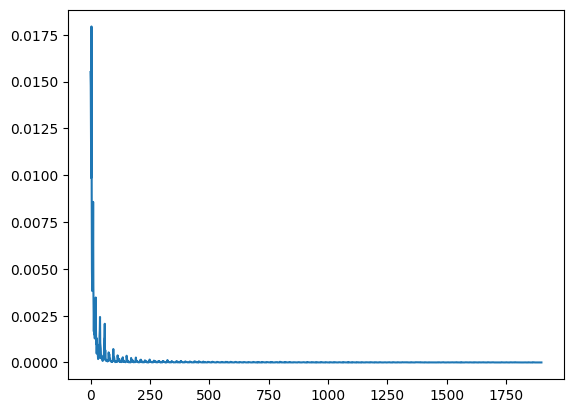

In [15]:
# ImageEncoderの学習 -> 要素がすべて0になる
num_iters_image_enc = 100
lr = 5e-4
F_image_enc = ImageEncoder().to(device)
optimizer_image_enc = optim.Adam(F_image_enc.parameters(), lr=lr)
# optimizer_image_enc = optim.SGD(F_image_enc.parameters(), lr=lr)
# 100 step後に5e-5になるように
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_image_enc, gamma=10**(-0.01))
criterion_TC = TimeContrastiveLoss()

history  = []
for iter in range(num_iters_image_enc):
    for t in range(1,images.shape[0]):
        t_cont = random.randint(0, t-1)
        images_t = torch.Tensor(images[t])
        images_t_cont = torch.Tensor(images[t_cont])
        time = torch.Tensor([t]).to(device)
        time_cont = torch.Tensor([t_cont]).to(device)
        while True:
            i = random.randint(0, images_t.shape[0]-1)
            j = random.randint(0, images_t.shape[0]-1)
            if i != j:
                break
        vt_i = F_image_enc(images_t[i].unsqueeze(0).permute(0,3,1,2).to(device), poses, time)
        vt_j = F_image_enc(images_t[j].unsqueeze(0).permute(0,3,1,2).to(device), poses, time)
        vt_cont_i = F_image_enc(images_t_cont[i].unsqueeze(0).permute(0,3,1,2).to(device), poses, time_cont)
        loss_image_enc = criterion_TC(vt_i, vt_j, vt_cont_i, alpha=0)
        if loss_image_enc > 0:
            optimizer_image_enc.zero_grad()
            loss_image_enc.backward()
            optimizer_image_enc.step()
        print(f'{iter}, {t}, {t_cont}, Time Contrastive Loss: {loss_image_enc}')
        
        history.append(loss_image_enc.item())
        
    scheduler.step()
        # print(vt_i)
        
plt.plot(history)
#plt.ylim(0, 0.1);

In [ ]:
# for file_name in natsorted(os.listdir('dataset')): # dataset分
# data_f = "test (4).npz"
# data = np.load(data_f)
# images = data["images"] / 255

#モデルの定義
F_dec = VeryTinyNeRFMLP().to(device)
optimizer_dec = optim.Adam(F_dec.parameters(), lr=lr)
criterion = nn.MSELoss()

num_loop = 10
scheduler_dec = optim.lr_scheduler.ExponentialLR(optimizer_dec, gamma=10**(-0.1))
num_iters = 100
display_every = 25


for loop in tqdm(range(num_loop)): 
    poses = torch.Tensor(poses).to(device) 
    for i in tqdm(range(num_iters)):

        t = random.randint(0, images.shape[0]-1) #ここあってるかわかんない
        images_t = torch.Tensor(images[t]).to(device)
        time = torch.Tensor([t]).to(device)

        target_img_idx = np.random.randint(images_t.shape[0]-1)
        target_pose = poses[target_img_idx].to(device)
        R = target_pose[:3, :3]
        ds = torch.einsum("ij,hwj->hwi", R, init_ds)
        os = (R @ init_o).expand(ds.shape)

        C_rs_c,_, _ = run_one_iter_of_tiny_nerf(
          images_t.permute(0,3,1,2).to(device), target_img_idx, poses, ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_image_enc, F_dec, time
        )

        loss_dec = criterion(C_rs_c, images_t[target_img_idx])
        optimizer_dec.zero_grad()
        loss_dec.backward(retain_graph=True)
        optimizer_dec.step()


        if (i+1) % display_every == 0:
            print(f"Loop: {loop}")
            print(f"Time Step: {t}")
            print(f"Iter: {i}")
            print(f"Loss: {loss_dec.item()}")
            plt.figure(figsize=(4, 4))
            plt.imshow(C_rs_c.detach().cpu().numpy())
            plt.show()

        for t in range(1,images.shape[0]):
            t_cont = random.randint(0, t-1)
            images_t = torch.Tensor(images[t])
            images_t_cont = torch.Tensor(images[t_cont])
            time = torch.Tensor([t]).to(device)
            time_cont = torch.Tensor([t_cont]).to(device)
            while True:
                i = random.randint(0, images_t.shape[0]-1)
                j = random.randint(0, images_t.shape[0]-1)
                if i != j:
                    break
            vt_i = F_image_enc(images_t[i].unsqueeze(0).permute(0,3,1,2).to(device), poses, time)
            vt_j = F_image_enc(images_t[j].unsqueeze(0).permute(0,3,1,2).to(device), poses, time)
            vt_cont_i = F_image_enc(images_t_cont[i].unsqueeze(0).permute(0,3,1,2).to(device), poses, time_cont)
            loss_image_enc = criterion_TC(vt_i, vt_j, vt_cont_i, alpha=0)
            loss_image_enc += loss_dec #loss_decはノルム取るべき？
            if loss_image_enc > 0:
                optimizer_image_enc.zero_grad()
                loss_image_enc.backward(retain_graph=True)
                optimizer_image_enc.step()
            if t == images.shape[0]:
                print(f'{iter}, {t}, {t_cont}, Time Contrastive Loss: {loss_image_enc}')
        
        scheduler.step()
    
    scheduler_dec.step()

  0%|          | 0/100 [00:00<?, ?it/s]

In [203]:
len(st)

20

Time: 0
View: 0
Loss: 0.0652049332857132
st: [tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4049, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1187, 0.0000, 0.0000, 0.2818,
        0.1366, 0.2095, 0.0000, 1.3840, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1744, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2669, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.2360, 0.1464, 0.0000,
        0.3623, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1331,
        0.0000, 0.5926, 0.0000, 0.2213, 0.0000, 0.0000, 0.6679, 0.4573, 0.0000,
        0.0000, 0.2504, 0.0044, 0.0978, 0.0051, 0.0573, 0.0000, 0.0000, 0.2744,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2702, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0152, 0.0344, 0.0000, 0.0000, 0.3183, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.4287, 0.0000, 0.0000, 0.0749, 0.0352, 0.0000, 0.0443,
        0.0000, 0.0000, 0.1774, 0.0000, 0.2177, 0.0000, 0.0000, 0.0000, 0.

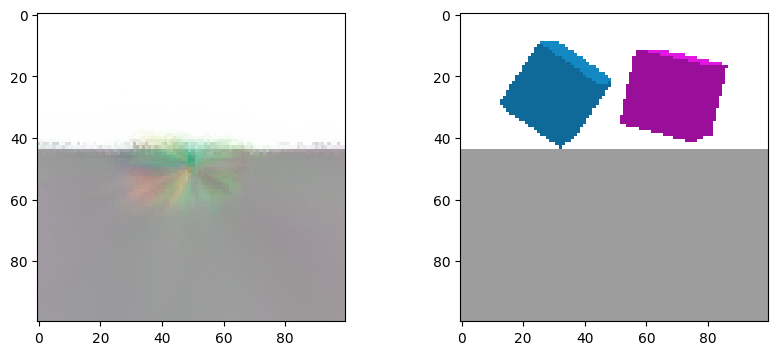

Time: 0
View: 1
Loss: 0.075614795088768
st: [tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3933, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1168, 0.0000, 0.0000, 0.2760,
        0.1333, 0.2037, 0.0000, 1.3482, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1711, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2611, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0195, 0.2290, 0.1440, 0.0000,
        0.3538, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1300,
        0.0000, 0.5775, 0.0000, 0.2163, 0.0000, 0.0000, 0.6519, 0.4473, 0.0000,
        0.0000, 0.2446, 0.0056, 0.0968, 0.0070, 0.0554, 0.0000, 0.0000, 0.2676,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2630, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0139, 0.0346, 0.0000, 0.0000, 0.3104, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.3915, 0.0000, 0.0000, 0.0745, 0.0325, 0.0000, 0.0436,
        0.0000, 0.0000, 0.1724, 0.0000, 0.2144, 0.0000, 0.0000, 0.0000, 0.1

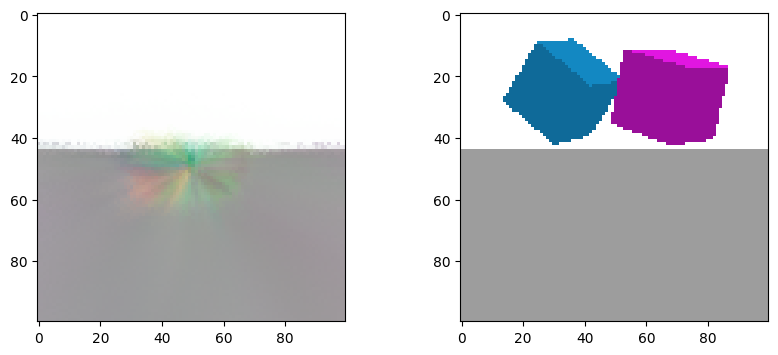

Time: 0
View: 2
Loss: 0.07392752170562744
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8560e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1649e-01, 0.0000e+00, 0.0000e+00, 2.7231e-01,
        1.3152e-01, 1.9962e-01, 0.0000e+00, 1.3253e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6860e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5682e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9545e-02,
        2.2443e-01, 1.4229e-01, 0.0000e+00, 3.4762e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2724e-01,
        0.0000e+00, 5.6757e-01, 0.0000e+00, 2.1356e-01, 0.0000e+00, 0.0000e+00,
        6.4198e-01, 4.4052e-01, 0.0000e+00, 0.0000e+00, 2.4027e-01, 6.8312e-03,
        9.6143e-02, 7.6388e-03, 5.4043e-02, 0.0000e+00, 0.0000e+00, 2.627

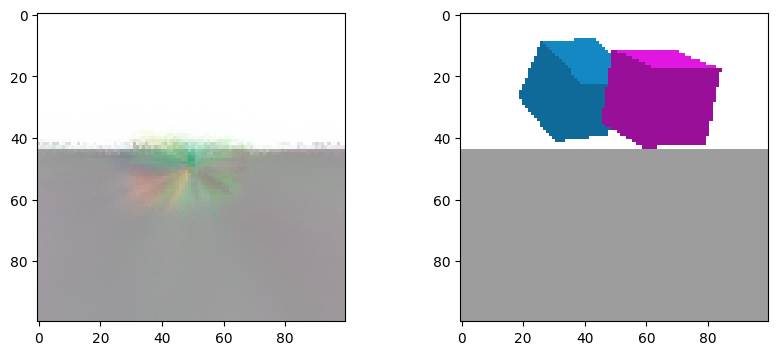

Time: 0
View: 3
Loss: 0.06092305853962898
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9509e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1763e-01, 0.0000e+00, 0.0000e+00, 2.7791e-01,
        1.3391e-01, 2.0462e-01, 0.0000e+00, 1.3574e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7136e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6065e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0378e-02,
        2.3015e-01, 1.4404e-01, 0.0000e+00, 3.5504e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2776e-01,
        0.0000e+00, 5.7974e-01, 0.0000e+00, 2.1758e-01, 0.0000e+00, 0.0000e+00,
        6.5511e-01, 4.4923e-01, 0.0000e+00, 0.0000e+00, 2.4470e-01, 5.3007e-03,
        9.5941e-02, 6.4484e-03, 5.5359e-02, 0.0000e+00, 0.0000e+00, 2.688

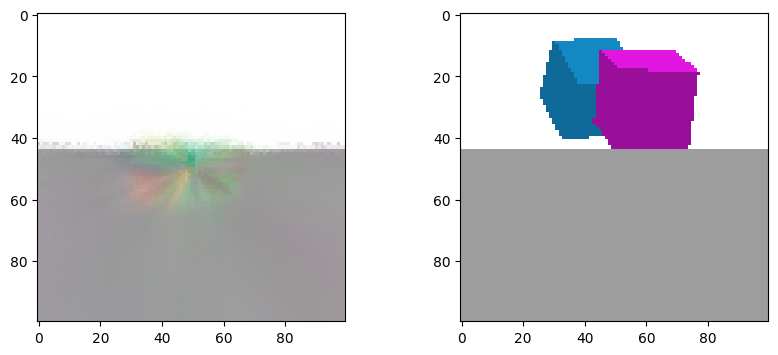

Time: 0
View: 4
Loss: 0.04069965332746506
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0453e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1930e-01, 0.0000e+00, 0.0000e+00, 2.8366e-01,
        1.3633e-01, 2.0955e-01, 0.0000e+00, 1.3886e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7376e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6496e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1318e-02,
        2.3585e-01, 1.4555e-01, 0.0000e+00, 3.6163e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2840e-01,
        0.0000e+00, 5.9156e-01, 0.0000e+00, 2.2203e-01, 0.0000e+00, 0.0000e+00,
        6.6863e-01, 4.5719e-01, 0.0000e+00, 0.0000e+00, 2.4905e-01, 4.4810e-03,
        9.6101e-02, 4.1807e-03, 5.6605e-02, 0.0000e+00, 0.0000e+00, 2.742

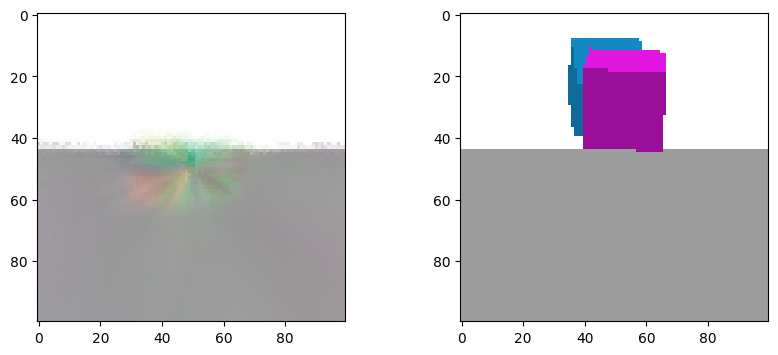

Time: 0
View: 5
Loss: 0.04379125311970711
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0345e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1891e-01, 0.0000e+00, 0.0000e+00, 2.8387e-01,
        1.3549e-01, 2.0937e-01, 0.0000e+00, 1.3852e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7287e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6403e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1138e-02,
        2.3518e-01, 1.4493e-01, 0.0000e+00, 3.5981e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2736e-01,
        0.0000e+00, 5.8982e-01, 0.0000e+00, 2.2104e-01, 0.0000e+00, 0.0000e+00,
        6.6703e-01, 4.5640e-01, 0.0000e+00, 0.0000e+00, 2.4797e-01, 4.5005e-03,
        9.5399e-02, 4.4898e-03, 5.6769e-02, 0.0000e+00, 0.0000e+00, 2.741

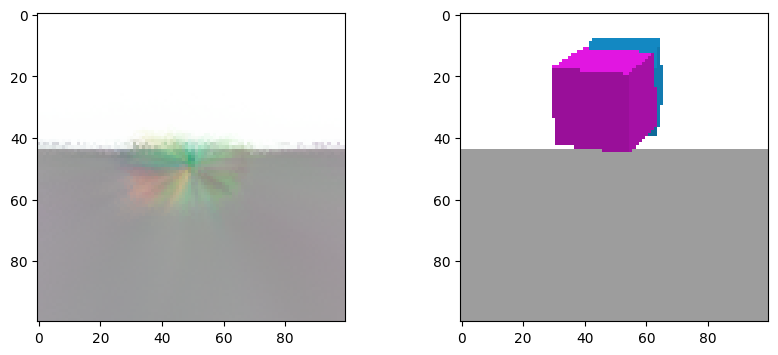

Time: 0
View: 6
Loss: 0.06006850674748421
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9982e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1840e-01, 0.0000e+00, 0.0000e+00, 2.8247e-01,
        1.3422e-01, 2.0824e-01, 0.0000e+00, 1.3737e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7170e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6227e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0762e-02,
        2.3300e-01, 1.4388e-01, 0.0000e+00, 3.5601e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2654e-01,
        0.0000e+00, 5.8480e-01, 0.0000e+00, 2.1922e-01, 0.0000e+00, 0.0000e+00,
        6.6220e-01, 4.5316e-01, 0.0000e+00, 0.0000e+00, 2.4520e-01, 5.0296e-03,
        9.5179e-02, 4.5956e-03, 5.6663e-02, 0.0000e+00, 0.0000e+00, 2.720

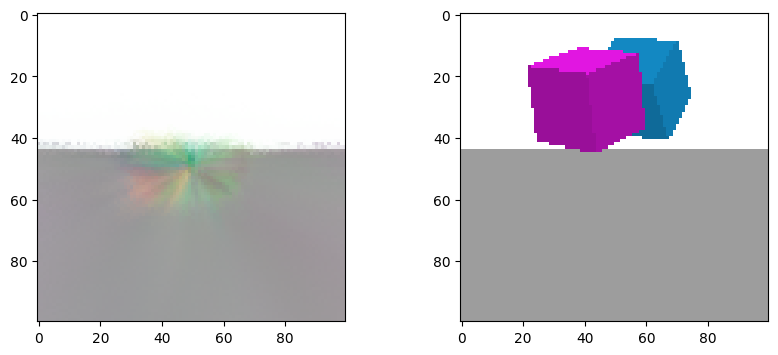

Time: 0
View: 7
Loss: 0.0696503296494484
st: [tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3902, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1169, 0.0000, 0.0000, 0.2772,
        0.1309, 0.2040, 0.0000, 1.3413, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1683, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2578, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0199, 0.2270, 0.1412, 0.0000,
        0.3469, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250,
        0.0000, 0.5716, 0.0000, 0.2142, 0.0000, 0.0000, 0.6484, 0.4444, 0.0000,
        0.0000, 0.2392, 0.0067, 0.0946, 0.0055, 0.0557, 0.0000, 0.0000, 0.2662,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2581, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0130, 0.0383, 0.0000, 0.0000, 0.3073, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.3798, 0.0000, 0.0000, 0.0730, 0.0333, 0.0000, 0.0431,
        0.0000, 0.0000, 0.1716, 0.0000, 0.2111, 0.0000, 0.0000, 0.0000, 0.

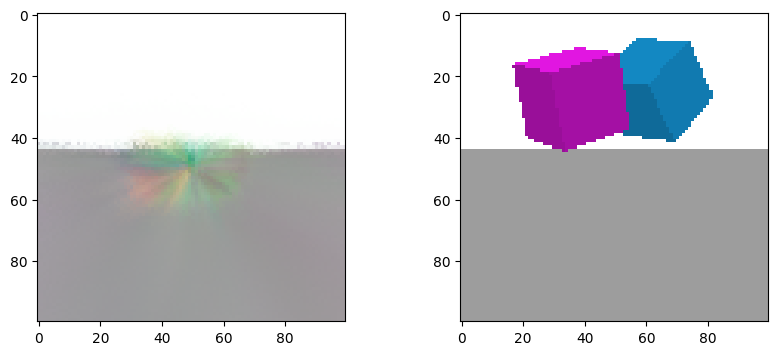

Time: 0
View: 8
Loss: 0.06647735089063644
st: [tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4029, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1183, 0.0000, 0.0000, 0.2841,
        0.1343, 0.2106, 0.0000, 1.3805, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1714, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2644, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0198, 0.2349, 0.1433, 0.0000,
        0.3556, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1276,
        0.0000, 0.5874, 0.0000, 0.2189, 0.0000, 0.0000, 0.6656, 0.4553, 0.0000,
        0.0000, 0.2453, 0.0053, 0.0954, 0.0034, 0.0578, 0.0000, 0.0000, 0.2737,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2653, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0146, 0.0389, 0.0000, 0.0000, 0.3153, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.4197, 0.0000, 0.0000, 0.0730, 0.0367, 0.0000, 0.0432,
        0.0000, 0.0000, 0.1772, 0.0000, 0.2147, 0.0000, 0.0000, 0.0000, 0

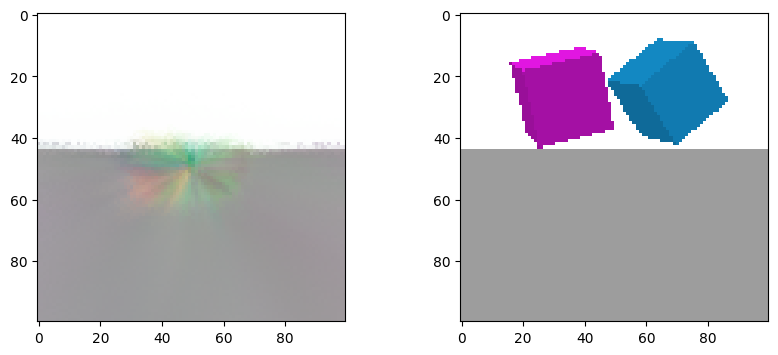

Time: 0
View: 9
Loss: 0.05775934457778931
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1236e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1919e-01, 0.0000e+00, 0.0000e+00, 2.8911e-01,
        1.3662e-01, 2.1582e-01, 0.0000e+00, 1.4094e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7434e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6925e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0007e-02,
        2.4069e-01, 1.4490e-01, 0.0000e+00, 3.6208e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2979e-01,
        0.0000e+00, 5.9937e-01, 0.0000e+00, 2.2230e-01, 0.0000e+00, 0.0000e+00,
        6.7852e-01, 4.6335e-01, 0.0000e+00, 0.0000e+00, 2.4981e-01, 4.3082e-03,
        9.5829e-02, 1.8034e-03, 5.9657e-02, 0.0000e+00, 0.0000e+00, 2.793

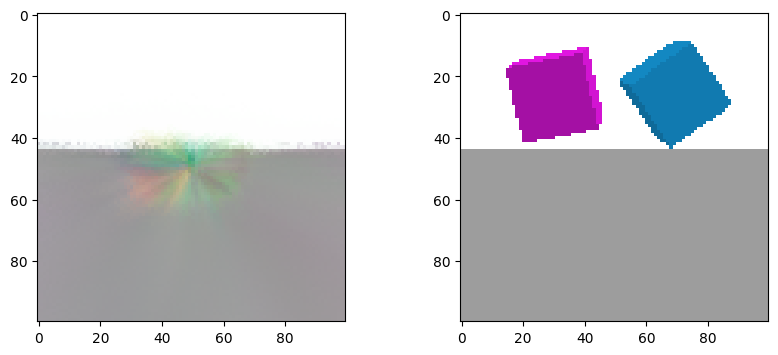

Time: 0
View: 10
Loss: 0.05625574663281441
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1253e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1901e-01, 0.0000e+00, 0.0000e+00, 2.8901e-01,
        1.3623e-01, 2.1614e-01, 0.0000e+00, 1.4077e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7413e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6996e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9409e-02,
        2.4093e-01, 1.4486e-01, 0.0000e+00, 3.6138e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3083e-01,
        0.0000e+00, 5.9923e-01, 0.0000e+00, 2.2191e-01, 0.0000e+00, 0.0000e+00,
        6.7834e-01, 4.6318e-01, 0.0000e+00, 0.0000e+00, 2.4958e-01, 4.4847e-03,
        9.5926e-02, 1.6676e-03, 5.9735e-02, 0.0000e+00, 0.0000e+00, 2.79

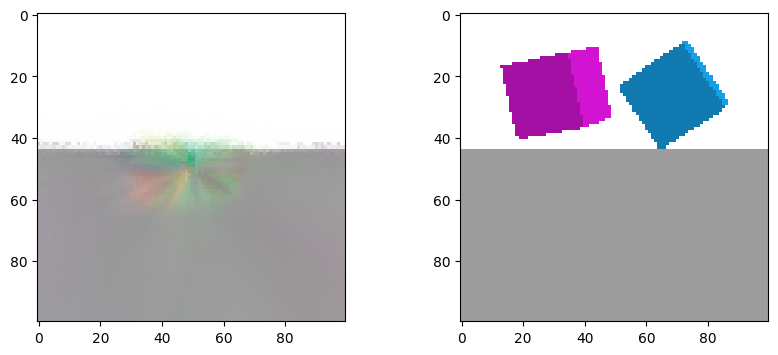

Time: 0
View: 11
Loss: 0.0618884339928627
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0374e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1802e-01, 0.0000e+00, 0.0000e+00, 2.8384e-01,
        1.3389e-01, 2.1191e-01, 0.0000e+00, 1.3771e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7114e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6650e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8787e-02,
        2.3635e-01, 1.4296e-01, 0.0000e+00, 3.5375e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3079e-01,
        0.0000e+00, 5.8741e-01, 0.0000e+00, 2.1715e-01, 0.0000e+00, 0.0000e+00,
        6.6609e-01, 4.5493e-01, 0.0000e+00, 0.0000e+00, 2.4507e-01, 5.9570e-03,
        9.6063e-02, 2.8353e-03, 5.9065e-02, 0.0000e+00, 0.0000e+00, 2.739

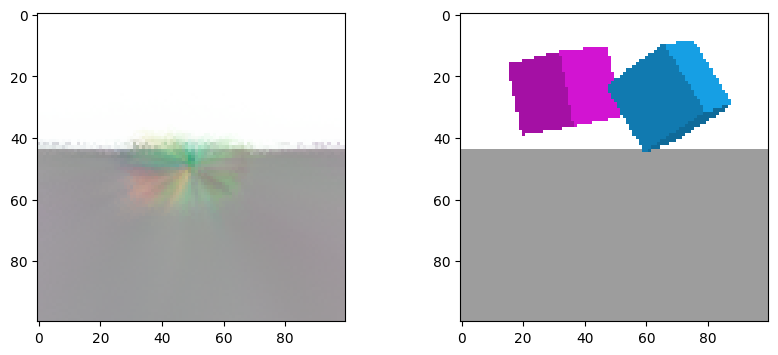

Time: 0
View: 12
Loss: 0.06142633408308029
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0201e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1786e-01, 0.0000e+00, 0.0000e+00, 2.8221e-01,
        1.3372e-01, 2.1118e-01, 0.0000e+00, 1.3697e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7049e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6669e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7940e-02,
        2.3531e-01, 1.4266e-01, 0.0000e+00, 3.5199e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3214e-01,
        0.0000e+00, 5.8487e-01, 0.0000e+00, 2.1576e-01, 0.0000e+00, 0.0000e+00,
        6.6293e-01, 4.5302e-01, 0.0000e+00, 0.0000e+00, 2.4467e-01, 5.9833e-03,
        9.6562e-02, 3.0301e-03, 5.8584e-02, 0.0000e+00, 0.0000e+00, 2.73

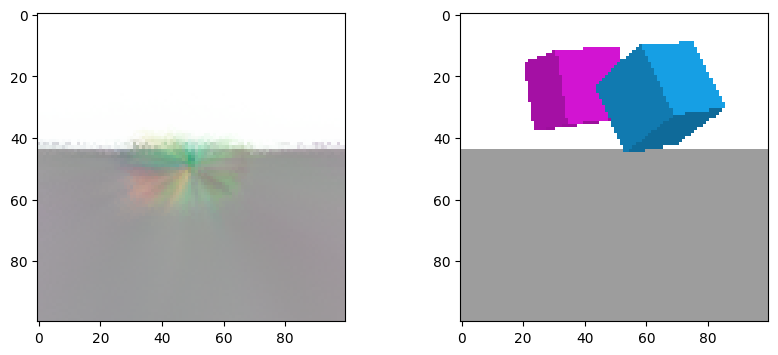

Time: 0
View: 13
Loss: 0.05303115397691727
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1174e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1879e-01, 0.0000e+00, 0.0000e+00, 2.8712e-01,
        1.3669e-01, 2.1549e-01, 0.0000e+00, 1.4005e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7390e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7172e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8443e-02,
        2.4134e-01, 1.4522e-01, 0.0000e+00, 3.6055e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3490e-01,
        0.0000e+00, 5.9824e-01, 0.0000e+00, 2.2021e-01, 0.0000e+00, 0.0000e+00,
        6.7654e-01, 4.6166e-01, 0.0000e+00, 0.0000e+00, 2.5068e-01, 4.9065e-03,
        9.7135e-02, 1.5798e-03, 5.9863e-02, 0.0000e+00, 0.0000e+00, 2.78

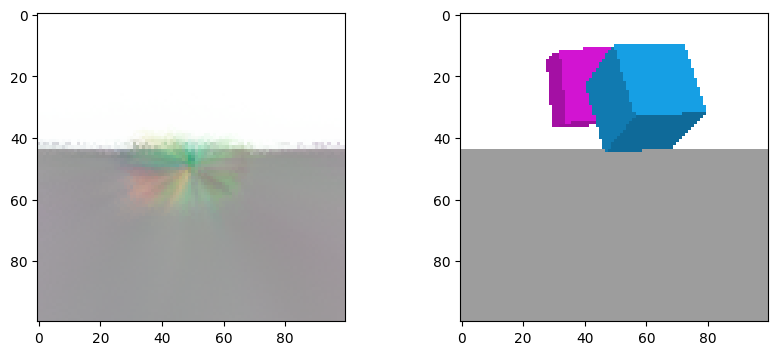

Time: 0
View: 14
Loss: 0.039850443601608276
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2006e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.2018e-01, 0.0000e+00, 0.0000e+00, 2.9078e-01,
        1.3927e-01, 2.1913e-01, 0.0000e+00, 1.4265e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7649e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7590e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8461e-02,
        2.4605e-01, 1.4718e-01, 0.0000e+00, 3.6751e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3714e-01,
        0.0000e+00, 6.0940e-01, 0.0000e+00, 2.2411e-01, 0.0000e+00, 0.0000e+00,
        6.8777e-01, 4.6890e-01, 0.0000e+00, 0.0000e+00, 2.5548e-01, 4.1046e-03,
        9.7777e-02, 5.4169e-04, 6.0871e-02, 0.0000e+00, 0.0000e+00, 2.8

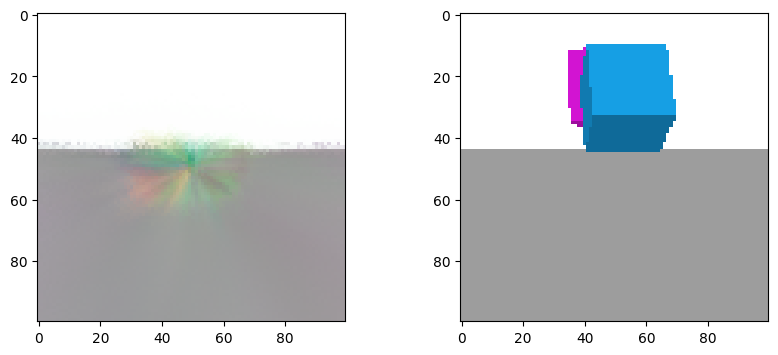

Time: 0
View: 15
Loss: 0.042445313185453415
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1422e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1942e-01, 0.0000e+00, 0.0000e+00, 2.8735e-01,
        1.3771e-01, 2.1555e-01, 0.0000e+00, 1.4064e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7513e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7317e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8214e-02,
        2.4271e-01, 1.4640e-01, 0.0000e+00, 3.6345e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3691e-01,
        0.0000e+00, 6.0221e-01, 0.0000e+00, 2.2184e-01, 0.0000e+00, 0.0000e+00,
        6.7936e-01, 4.6351e-01, 0.0000e+00, 0.0000e+00, 2.5302e-01, 4.8666e-03,
        9.7955e-02, 1.9303e-03, 5.9833e-02, 0.0000e+00, 0.0000e+00, 2.7

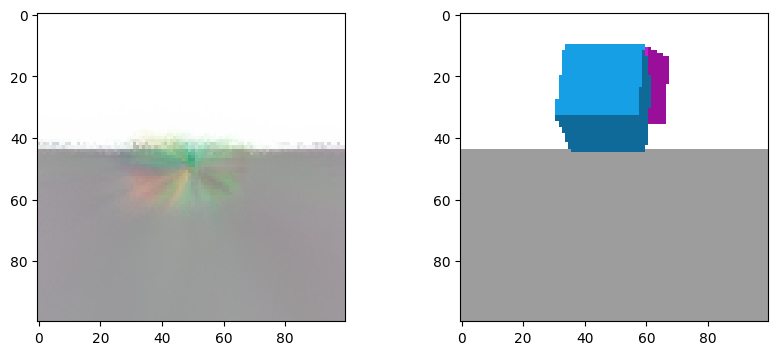

Time: 0
View: 16
Loss: 0.058393049985170364
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0472e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1818e-01, 0.0000e+00, 0.0000e+00, 2.8176e-01,
        1.3576e-01, 2.1068e-01, 0.0000e+00, 1.3775e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7289e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6884e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7880e-02,
        2.3704e-01, 1.4467e-01, 0.0000e+00, 3.5739e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3548e-01,
        0.0000e+00, 5.9037e-01, 0.0000e+00, 2.1825e-01, 0.0000e+00, 0.0000e+00,
        6.6676e-01, 4.5576e-01, 0.0000e+00, 0.0000e+00, 2.4884e-01, 5.6366e-03,
        9.7845e-02, 3.4459e-03, 5.8374e-02, 0.0000e+00, 0.0000e+00, 2.7

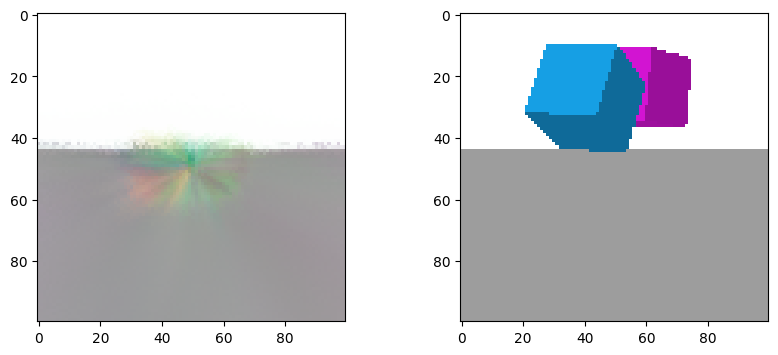

Time: 0
View: 17
Loss: 0.06667128950357437
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9477e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1718e-01, 0.0000e+00, 0.0000e+00, 2.7631e-01,
        1.3335e-01, 2.0523e-01, 0.0000e+00, 1.3465e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7033e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6394e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7612e-02,
        2.3109e-01, 1.4346e-01, 0.0000e+00, 3.5106e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3377e-01,
        0.0000e+00, 5.7815e-01, 0.0000e+00, 2.1454e-01, 0.0000e+00, 0.0000e+00,
        6.5323e-01, 4.4730e-01, 0.0000e+00, 0.0000e+00, 2.4448e-01, 6.4522e-03,
        9.7773e-02, 5.7278e-03, 5.7000e-02, 0.0000e+00, 0.0000e+00, 2.68

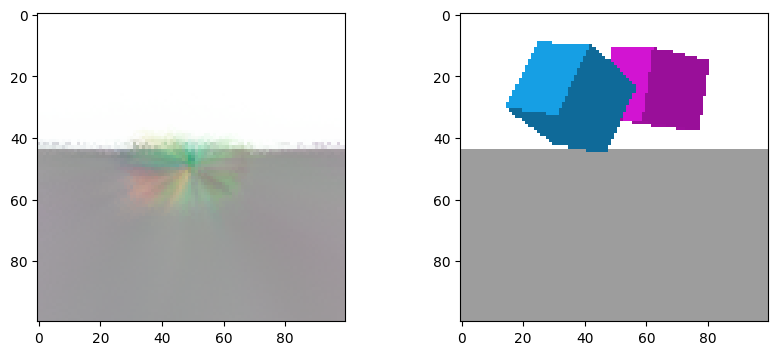

Time: 0
View: 18
Loss: 0.06517291814088821
st: [tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0770e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.1910e-01, 0.0000e+00, 0.0000e+00, 2.8293e-01,
        1.3707e-01, 2.1112e-01, 0.0000e+00, 1.3894e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7440e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6910e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9047e-02,
        2.3824e-01, 1.4640e-01, 0.0000e+00, 3.6234e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3532e-01,
        0.0000e+00, 5.9529e-01, 0.0000e+00, 2.2110e-01, 0.0000e+00, 0.0000e+00,
        6.7077e-01, 4.5904e-01, 0.0000e+00, 0.0000e+00, 2.5118e-01, 4.7723e-03,
        9.8138e-02, 4.2914e-03, 5.8348e-02, 0.0000e+00, 0.0000e+00, 2.76

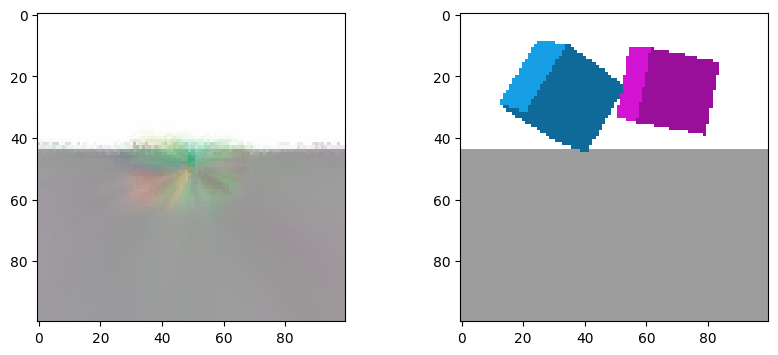

Time: 1
View: 0
Loss: 0.06538652628660202
st: [tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4047, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1187, 0.0000, 0.0000, 0.2817,
        0.1366, 0.2092, 0.0000, 1.3831, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1743, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2668, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.2360, 0.1461, 0.0000,
        0.3619, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1330,
        0.0000, 0.5923, 0.0000, 0.2212, 0.0000, 0.0000, 0.6674, 0.4570, 0.0000,
        0.0000, 0.2502, 0.0043, 0.0978, 0.0052, 0.0572, 0.0000, 0.0000, 0.2743,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2701, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0152, 0.0343, 0.0000, 0.0000, 0.3180, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.4278, 0.0000, 0.0000, 0.0748, 0.0351, 0.0000, 0.0443,
        0.0000, 0.0000, 0.1775, 0.0000, 0.2175, 0.0000, 0.0000, 0.0000, 0

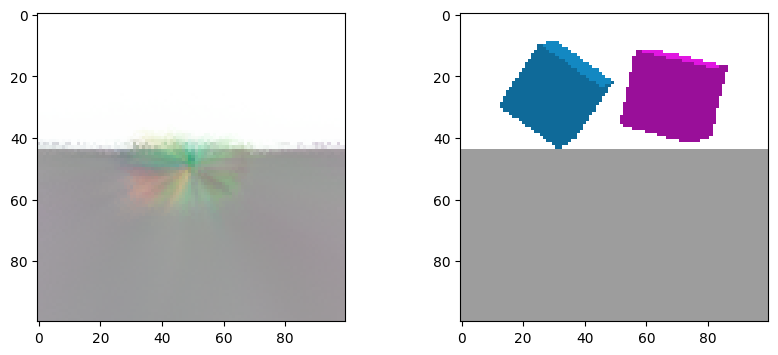

Time: 1
View: 1
Loss: 0.07581723481416702


KeyboardInterrupt: 

In [191]:
# 新規視点の描画
test_data_f = "test_2box.npz"
test_data = np.load(test_data_f)
test_images = test_data["images"][:20] / 255
test_poses = torch.Tensor(test_data["poses"].reshape((-1,4,4))).to(device)
F_dec_out_st = VeryTinyNeRFMLP().to(device)
cpt = torch.load('out_2box.cpt')
F_dec_out_st.load_state_dict(cpt['decoder_state_dict'])
F_image_enc.eval()
F_dec_out_st.eval()
for t in range(test_images.shape[0]):
    for test_idx in range(test_images.shape[1]):
        test_R = torch.Tensor(test_poses[test_idx, :3, :3]).to(device)
        test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
        test_os = (test_R @ init_o).expand(test_ds.shape)
        test_img = torch.Tensor(test_images[t][test_idx]).to(device)
        test_pose = torch.Tensor(test_poses[test_idx]).unsqueeze(0).to(device)
        with torch.no_grad():
            C_rs_c_test, vt_test, st = run_one_iter_of_tiny_nerf(
                test_img.unsqueeze(0).permute(0,3,1,2), target_img_idx, test_pose, test_ds, N_c, t_i_c_bin_edges, t_i_c_gap, test_os, chunk_size, F_image_enc, F_dec_out_st
            )
        loss_dec = criterion(C_rs_c_test, test_img)
        print(f"Time: {t}")
        print(f"View: {test_idx}")
        print(f"Loss: {loss_dec.item()}")
        print(f"st: {st}")
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_c.detach().cpu().numpy())
        plt.subplot(122)
        plt.imshow(test_img.detach().cpu().numpy())
        plt.show()

In [159]:
test_ds.shape

torch.Size([100, 100, 3])

In [150]:
test_images.shape

(20, 19, 100, 100, 3)

In [148]:
file_name = 'out_2box.cpt'
torch.save({
'time': 0,
'loop': 4,
'image_encoder_state_dict': F_image_enc.state_dict(), # vtまでのencoder
'decoder_state_dict': F_dec.state_dict(),
'opt_img_enc_state_dict': optimizer_image_enc.state_dict(),
'opt_dec_state_dict': optimizer_dec.state_dict(),
'loss': loss_dec,
}, file_name)

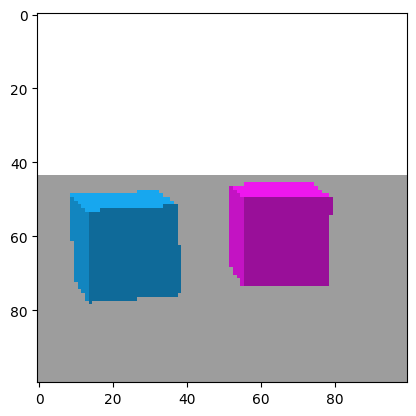

In [141]:
plt.imshow(images[20][19])

In [207]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch
